In [1]:
import numpy as np
from numpy.random import choice
import pandas as pd
import random
import plotly.express as px
import plotly.graph_objects as go
import datetime 

import matplotlib.pyplot as plt
import math

from IPython.core.debugger import set_trace
from IPython.display import clear_output

from r_learning import Agent
from data.get_data import *


%load_ext autoreload
%autoreload 2

In [2]:
OLD = ["BTC", "ETH", "DASH", "LTC", "XMR"]
BOOMS = ["CAKE", "FTM", "DEXE", "MATIC", "SOL", "SC", "BNB"]

ASSETS = OLD
START = "2023-01"
END = "2023-05"

#data = get_data(interval="1d", assets = ASSETS, start=START, end=END).dropna()

In [3]:
data = Get_data(asset="DASH").loc[START : END]
data.shape

(151, 6)

In [4]:
data

,open,high,low,close,volume,symbol
time,,,,,,
2023-01-01,42.05,42.45,41.11,42.21,58827.156,DASHUSDT
2023-01-02,42.22,44.06,41.48,43.56,117917.439,DASHUSDT
2023-01-03,43.57,43.93,42.24,42.86,98037.663,DASHUSDT
2023-01-04,42.84,46.40,42.67,45.79,123599.552,DASHUSDT
2023-01-05,45.77,46.20,44.55,44.90,87559.368,DASHUSDT
...,...,...,...,...,...,...
2023-05-27,41.91,42.50,41.40,42.21,28528.006,DASHUSDT
2023-05-28,42.21,44.42,42.08,43.84,47190.616,DASHUSDT
2023-05-29,43.84,44.10,42.87,43.31,41563.879,DASHUSDT


# Case Study 1

In [5]:
X=list(data["close"])
X=[float(x) for x in X]


validation_size = 0.3
#In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

In [6]:
import numpy as np
import math

# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))


# returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t
def getState(data, t, n):    
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

In [7]:
import time

--------------------------------
Total Profit: $3.15
--------------------------------


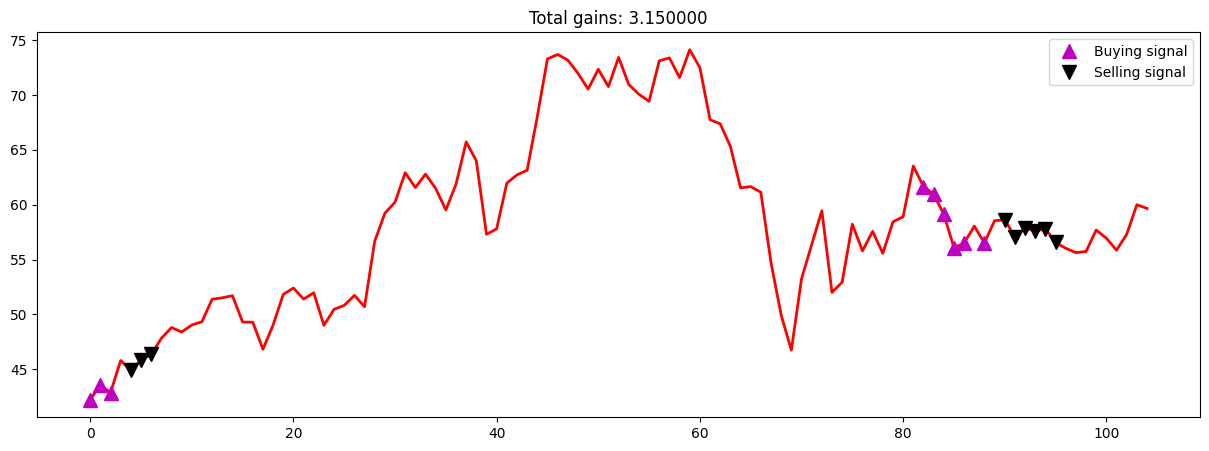

agent :  1000
batch_size :  16
1/1 [==============================] - 0s 29ms/step


INFO:tensorflow:Assets written to: model_ep10\assets


INFO:tensorflow:Assets written to: model_ep10\assets


In [8]:
from IPython.core.debugger import set_trace
window_size = 1
agent = Agent(window_size)
#In this step we feed the closing value of the stock price 
data = X_train
l = len(data) - 1
#
batch_size = 16
#An episode represents a complete pass over the data.
episode_count = 10

for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)
    #set_trace()
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in range(l):
        clear_output(wait = True)
        print("t : ",t)
        action = agent.act(state)    
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            #print("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)      
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            #print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

        done = True if t == l - 1 else False
        #appends the details of the state action etc in the memory, which is used further by the exeReply function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        
        if done:
            clear_output(wait = True)
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            #set_trace()
            #pd.DataFrame(np.array(agent.memory)).to_csv("Agent"+str(e)+".csv")
            #Chart to show how the model performs with the stock goin up and down for each 
            plot_behavior(data,states_buy, states_sell, total_profit)
            time.sleep(60)
        print("agent : ",len(agent.memory))
        print("batch_size : ",batch_size)
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)    
            

    if e % 2 == 0:
        agent.model.save("model_ep" + str(e))

In [9]:
#agent is already defined in the training set above.
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
#Get the trained model
model_name = "model_ep"+str(episode_count)
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []

1/1 [==============================] - 0s 27ms/step
------------------------------------------
Total Profit: $0.00
------------------------------------------


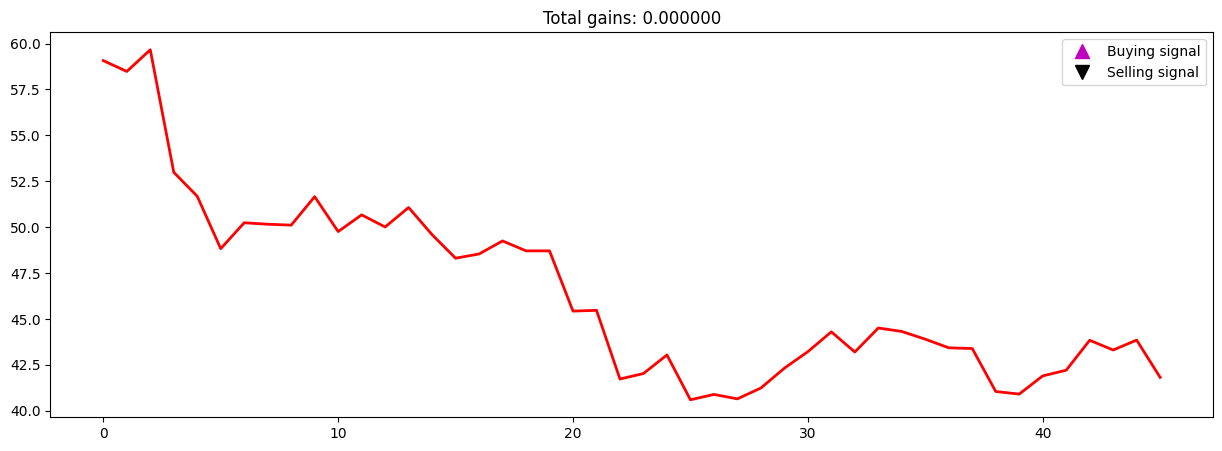

In [10]:
for t in range(l_test):
    action = agent.act(state)
    #print(action)
    #set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(test_data[t])
        states_buy_test.append(t)
        print("Buy: " + formatPrice(test_data[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        #reward = test_data[t] - bought_price
        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
        print("Sell: " + formatPrice(test_data[t]) + " | profit: " + formatPrice(test_data[t] - bought_price))

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")
        
plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)

# Case Study 3

In [11]:
class CrytoEnvironment:
    
    def __init__(self, assets, capital):
        self.assets = assets
        self.capital = capital
        self.data = self.load_data()
        
    def load_data(self):
        Get_m_data()        
    
    def preprocess_state(self, state):
        return state
    
    def get_state(self, t, lookback, is_cov_matrix=True, is_raw_time_series=False):
        assert lookback <= t
        
        decision_making_state = self.data.iloc[t - lookback:t]
        decision_making_state = decision_making_state.pct_change().dropna()
        
        if is_cov_matrix:
            x = decision_making_state.cov()
            return x
        else:
            if is_raw_time_series:
                decision_making_state = self.data.iloc[t-lookback : t]
            return self.preprocess_state(decision_making_state)
    
    def get_reward(self, action, action_t, reward_t, alpha=0.01):
        
        def local_portfolio(returns, weights):
            weights = np.array(weights)
            rets = returns.mean()   # * 252
            covs = returns.cov()    # * 252
            P_ret = np.sum(rets * weights)
            P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
            P_sharpe = P_ret / P_vol
            return np.array([P_ret, P_vol, P_sharpe])
        
        data_period = self.data[action_t : reward_t]
        weights = action 
        returns = data_period.pct_change().dropna()
        
        sharpe = local_portfolio(returns, weights)[-1]
        sharpe = np.array([sharpe] * len(self.data.columns))
        ret = (data_period.values[-1] - data_period.valuesp[0]) / data_period.values[0]
        
        return np.dot(returns, weights), ret
    